<a href="https://colab.research.google.com/github/vvedhas/Coursera_Capstone/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Battle of Neighborhoods :
New York and Toronto 


1. **Introduction**

1.1 **Preface**

The cities of New York and Toronto are perhaps two of the most well known cities in the world. Both being prominent financial capitals for their nations, the cities boast a wide array of people, coming with their diverse cultures and yet, leading similar lifestyles that represent the city.
New York, better known as New York City, is the most densely populated city in the United States. Located on the southern tip of the State of New York, it is also the world's largest metropolitan area.
Toronto, the capital of Ontario, Canada, is Canada’s most populous city. Located in a geographically diverse area, Toronto is famous for its valleys, forests and mountains. While the primary language for communication is English, Toronto boasts over 160 different languages.

1.2 **Business Problem**

The cities are both densely populated and house a diverse range of people. This report aims to discover and list a few similarities and dissimilarities between the two cities, and showcase what is more popular among the residents of the cities.

1.3 **Scope**

It is always helpful to know about a city beforehand when planning to visit. Additionally, by identifying the trends and activities of a city, it allows for smarter decisions in opening businesses, looking for jobs and many other activities.




2. **Data Handling**

2.1 **Overview** 

The analysis begins by acquiring the neighborhood data of both cities, which can be procured from the Wikipedia pages of the cities. Some of the data we shall use will be Boroughs, Neighborhoods, and Postcodes. These attributes can be scraped from the webpage tables, and can be cleaned up using the BeautifulSoup Library.

Further, the cleaned data can be correlated via Foursquare to obtain data of popular venues in the areas we have listed, which is key to identifying trends in the cities.

This data will further be used to identify key demographic interests and other observations.


2.2 **Data Gathering**

We begin by collecting the list of neighborhoods in both New York and Toronto. We do this by scraping webpages for the data, and storing them in pandas dataframes.

In [65]:
# importing all the required libraries
!pip install geocoder
import pandas as pd
import json
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
from geopy.geocoders import Nominatim
import geocoder
import folium
from os import path
# import k-means from clustering stage
from sklearn.cluster import KMeans
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.cm as cm
import matplotlib.colors as colors

In [66]:
#Downloading New York database
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)

Now, the database for Toronto

In [67]:
temp=requests.get("https://web.archive.org/web/20181110230135/https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup=BeautifulSoup(temp,'lxml')
from IPython.display import display_html
tab = str(soup.table)
dfs = pd.read_html(tab)
df=dfs[0]
df1 = df[df.Borough != 'Not assigned']
df2 = df1.groupby(['Postcode','Borough'], sort=False).agg(', '.join)
df2.reset_index(inplace=True)
df2['Neighbourhood'] = np.where(df2['Neighbourhood'] == 'Not assigned',df2['Borough'], df2['Neighbourhood'])

We now have a list of boroughs and neighborhoods for both NY and Toronto. Now, we  get Latitudes and Longitudes for both these tables so we may input that data into the FourSquare API

In [68]:
#Latitudes and Longitudes for NY Table
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [69]:
#Latitudes and Longitudes for Toronto Table
lat_lon = pd.read_csv('https://cocl.us/Geospatial_data')
lat_lon.rename(columns={'Postal Code':'Postcode'},inplace=True)
df3 = pd.merge(df2,lat_lon,on='Postcode')
df3.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


3. **Exploratory Data Analysis**

3.1 **Mapping Locations**

In [70]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [71]:
#Mapping Toronto
map_toronto = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

for lat,lng,borough,neighbourhood in zip(df3['Latitude'],df3['Longitude'],df3['Borough'],df3['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_toronto)
map_toronto

3.2 **Venue information**

In [72]:
#Setting up FourSquare API
CLIENT_ID = 'B2YF0MTXYTA004JOFJB3NUPAVXNGNWN05AKWIO1MW35OGHCU'  # your Foursquare ID
CLIENT_SECRET = 'RCQDB0RFPT53AGVFGHKOOG0LG2JPGOVZ5E0SUGHIV2PRZ1NB'  # your Foursquare Secret
VERSION = '20191031'
LIMIT = 100


def getNearbyVenues(names, latitudes, longitudes, radius=500):

    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([
            (name, lat, lng, v['venue']['name'], v['venue']['location']['lat'],
             v['venue']['location']['lng'],
             v['venue']['categories'][0]['name']) for v in results
        ])

    nearby_venues = pd.DataFrame(
        [item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
        'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'
    ]

    return (nearby_venues)


In [73]:
#Getting NY Venues
NY_venues= getNearbyVenues(names=neighborhoods['Neighborhood'],
                                latitudes=neighborhoods['Latitude'],
                                longitudes=neighborhoods['Longitude'])

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [74]:
#Getting Toronto Venues
toronto_venues= getNearbyVenues(names=df3['Neighbourhood'],
                                latitudes=df3['Latitude'],
                                longitudes=df3['Longitude'])

Parkwoods
Victoria Village
Harbourfront, Regent Park
Lawrence Heights, Lawrence Manor
Queen's Park
Islington Avenue
Rouge, Malvern
Don Mills North
Woodbine Gardens, Parkview Hill
Ryerson, Garden District
Glencairn
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
Highland Creek, Rouge Hill, Port Union
Flemingdon Park, Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Downsview North, Wilson Heights
Thorncliffe Park
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
East Birchmount Park, Ionview, Kennedy Park
Bayview Village
CFB Toronto, Downsview East
The D

3.3 **Generating Word Cloud to identify trends**

In [75]:
#Function for word cloud
def generate_word_cloud(string):
    wordcloud = WordCloud(width=800, height=400,background_color="white").generate(string)
    fig= plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
NY_venue_categories = " ".join(
    venue for venue in NY_venues["Venue Category"])
toronto_venue_categories = " ".join(
    venue for venue in toronto_venues["Venue Category"])

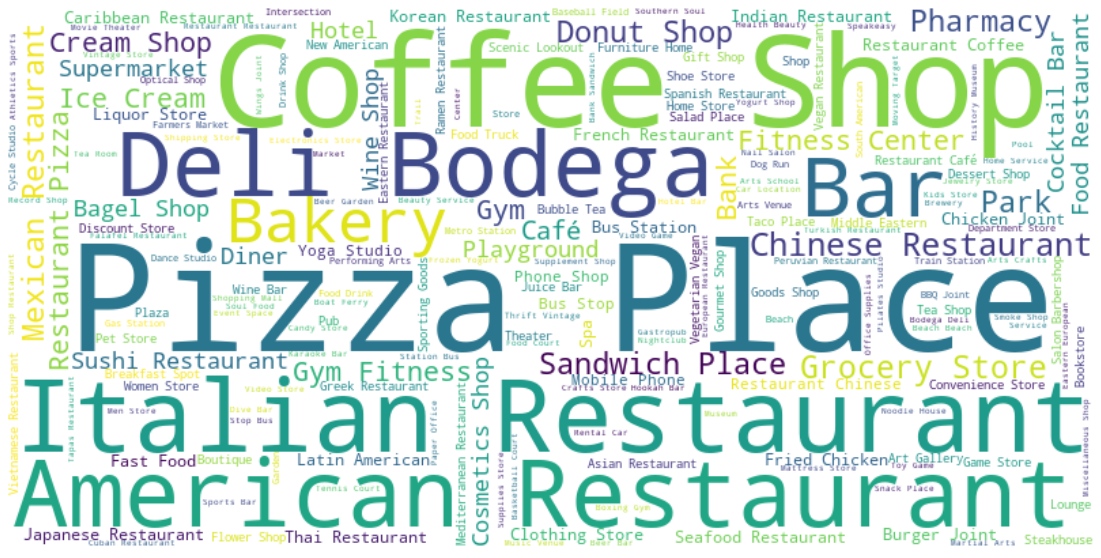

In [76]:
generate_word_cloud(NY_venue_categories)

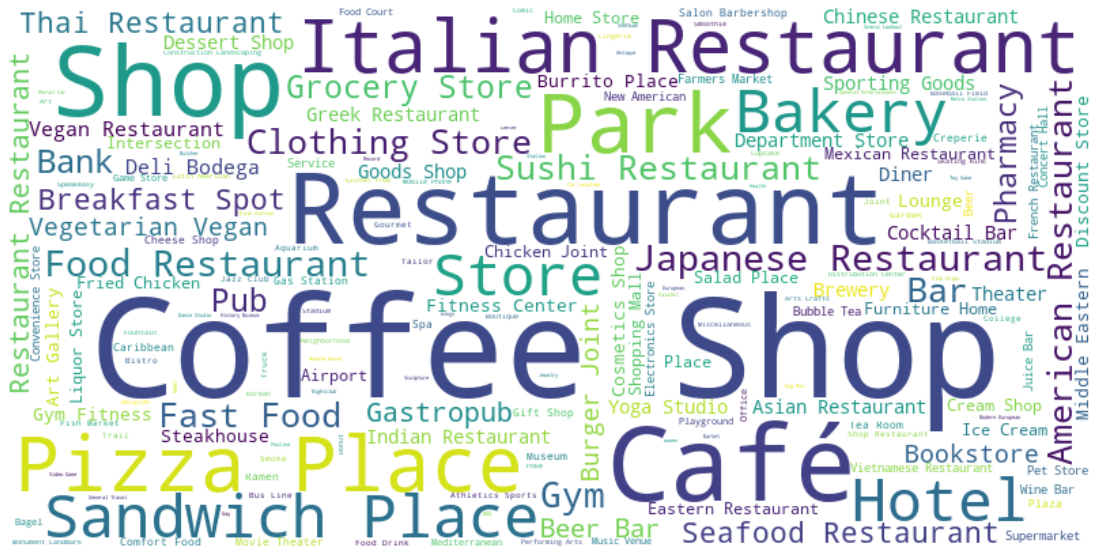

In [77]:
generate_word_cloud(toronto_venue_categories)

4. **Clustering the Neighbourhoods**

In [78]:
# one hot encoding
ny_onehot = pd.get_dummies(NY_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = NY_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_grouped=ny_onehot.groupby('Neighborhood').mean().reset_index()
print(ny_grouped.shape)

to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

to_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

to_grouped=to_onehot.groupby('Neighborhood').mean().reset_index()
to_grouped.shape

(302, 437)


(99, 271)

In [79]:
#Using K-means clustering on the venue tables
k=5
toronto_clustering = df3.drop(['Postcode','Borough','Neighbourhood'],1)
kmeans = KMeans(n_clusters = k,random_state=0).fit(toronto_clustering)
kmeans.labels_
df3.insert(0, 'Cluster Labels', kmeans.labels_)

k=5
ny_clustering = neighborhoods.drop(['Borough','Neighborhood'],1)
kmeans = KMeans(n_clusters = k,random_state=0).fit(ny_clustering)
kmeans.labels_
neighborhoods.insert(0, 'Cluster Labels', kmeans.labels_)

In [80]:
#Mapping Toronto Neighborhood clusters
# create map
map_clusters = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(df3['Latitude'], df3['Longitude'], df3['Neighbourhood'], df3['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [81]:
#Mapping New York Clusters
# create map
map_clusters = folium.Map(location=[latitude,longitude],zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood'], neighborhoods['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

5. **Observations**

From our processes, we can glean some interesting information. Firstly, we can see how the neighborhoods are divided and distributed through the clustering. This allows us to infer where people will tend to spend most of their time around, and assist in planning for new businesses.

The word clouds generated tell us a few stories. We can see how New Yorkers prefer going to pizza places, which matches up with the generally fast-paced lifestyle one would lead there, which the average Torontoian would prefer to relax and spend their time in a coffee shop. In Asian Food, New York has a penchant for Chinese, which is a stellar example of the quick takeaway food New Yorkers prefer, which is another insight into their lifestyle. Toronto prefers Japanese food, which is traditionally had sitting down in the restaurant rather tan takeaway, which insinuates a somewhat slower pace of life there.

The high presence of Delis, Bodegas and grocery shops in New York tell us that New Yorkers would rather spend as much time possible at home, and do more shopping for take-home stuff. On the other hand, Toronto shows more interest in cafes, parks and other places, where one would spend their time, and maybe enrich themselves culturally.

So we can see, while both cities are usually regarded as the most busy cities in their countries, the lives of New Yorkers tend to be much faster and more goal-oriented than someone from Toronto, who would prefer to take their time out for breaks and relax, for mental well-being.